In [239]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
import random
from preproc import *
from itertools import combinations
from scipy.special import factorial
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import textwrap
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, ClassifierMixin



In [240]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [241]:
good_cell_labels = list()
with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
print(good_cell_labels)

['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch19c2', '20181102ch26c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181102ch45c1', '20181102ch45c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c1', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181101ch45c1', '20181031ch19c1', '20181031ch19c2', '20181031ch19c3', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch30c2', '20181031ch35c1', '20181031ch35c2', '20181031ch35c3', '20181031ch43c1', '20181031ch43c2', '20181031ch45c1', '20181031ch45c2', '20181026ch19c1', '20181026ch19c2', '20181026ch19c3', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch35c3', '20181026c

In [504]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True
# Save Figures
to_save = True
figsave_dir = 'figures/population_prob_distribution'

In [243]:
#Read placeist files
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])

In [692]:
# Set amount of bins, see which cells are valid for testing 
total_bins = 21
two_thirds = 20
valid_dist_size = 2
valid_cells_distribution = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        total_valid_bins = list()
        # if 2/3 of the bins contain over 30 samples, the cell is valid
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if dist.size > valid_dist_size:
                total_valid_bins.append(bin)

        if len(total_valid_bins) > two_thirds:
            valid_cells_distribution.append(label)
            
print('Amount of valid cells:', len(valid_cells_distribution))
train_size = int(round((len(valid_cells_distribution) * 0.7),0))
test_size = int(round((len(valid_cells_distribution) * 0.3),0))
print(train_size)
print(test_size)
print(valid_cells_distribution)
list_nums = list(range(1,(len(valid_cells_distribution) + 1)))
valid_cell_to_num = dict(zip(valid_cells_distribution, list_nums))

print(valid_cell_to_num)
new_day_list = list()

for cell in valid_cells_distribution:
    new_day = cell[:8]
    new_day_list.append(new_day)


Amount of valid cells: 276
193
83
['20181105ch29c1', '20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181101ch19c1', '20181101ch21c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch43c1', '20181031ch19c2', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c2', '20181022ch43c4', '20181022ch45c1', '20181022ch93c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch6c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch29c1', '20181011ch45c1', '20181011ch45c2', '20181011ch45c3', '20181010ch45

In [526]:
bins_data = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data:
                bins_data[bin] = []
            bins_data[bin].append(dist)


In [527]:
# normalized to the sum 
for key, distributions in bins_data.items():
    for i in range(len(distributions)):
        distribution = distributions[i]
        total = sum(distribution)
        distributions[i] = [float(i) / total for i in distribution]

In [573]:
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        for i in range(num_sess_cells):
            cell_label = data['cell_labels'][i]
            if cell_label in valid_cells_distribution:
                all_place_responses.append(data['place_responses_per_cell'][i])
                all_place_durations.append(data['durations_per_place'])
                all_cell_labels.append(cell_label)

num_all_cells = len(all_cell_labels)
print(all_cell_labels)

['20181105ch29c1', '20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181101ch19c1', '20181101ch21c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch43c1', '20181031ch19c2', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c2', '20181022ch43c4', '20181022ch45c1', '20181022ch93c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch6c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch29c1', '20181011ch45c1', '20181011ch45c2', '20181011ch45c3', '20181010ch45c1', '20181009ch45c1', '20181009ch

In [529]:
for cell, place_responses_per_cell in enumerate(all_place_responses):
    print(cell)
    num_bins = 25
    response_params_per_cell = np.zeros((num_bins+1, 3))
    place_durations_per_cell = all_place_durations[cell]
    for bin, dist in place_responses_per_cell.items():
        total = sum(dist)
        dist= [float(i) / total for i in dist]
        response_params_per_cell[bin,0] = np.mean(dist)
        response_params_per_cell[bin,1] = np.std(dist, ddof=1)
        response_params_per_cell[bin,2] = np.sum(place_durations_per_cell[bin])
    response_params_per_cell[:,2] = response_params_per_cell[:,2] / np.sum(response_params_per_cell[:,2])
    all_place_responses[cell] = response_params_per_cell
all_place_responses = np.array(all_place_responses)

# Clean up large memory variables
del all_place_durations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [515]:
from scipy.stats import lognorm
from scipy.stats import expon
from collections import Counter

class BayesDecoder:
    def __init__(self, dist):
        self.dist = dist
        self.num_cells = dist.shape[0]
        self.num_bins = dist.shape[1]
        
    def gaussian_pdf(x, mu, sig):
        return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
    
    def __likelihood(self, x, cell, bin):
        mu, sig = self.dist[cell,bin,0], self.dist[cell,bin,1]
        return BayesDecoder.gaussian_pdf(x, mu, sig)
    
    def __predict_cell(self, x, cell):
        posterior = np.zeros(self.num_bins)
        for bin in range(1, self.num_bins):
            prior = self.dist[cell,bin,2]
            posterior[bin] = prior * self.__likelihood(x, cell, bin)
        posterior = np.nan_to_num(posterior, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        pred = np.argmax(posterior[1:])
        return pred, posterior[pred] 

    def predict(self, x):
        prediction, confidence = np.zeros(self.num_cells), np.zeros(self.num_cells)
        for cell in range(self.num_cells):
            pred, conf = self.__predict_cell(x[cell], cell)
            prediction[cell] = pred
            confidence[cell] = conf
        unique_preds, counts = np.unique(prediction, return_counts=True)
        #return lines
        most_common_pred = unique_preds[np.argmax(counts)]
        counts = Counter(prediction)
        most_common = counts.most_common(5)
        total_count = len(prediction)
        unique_proportions = {int(unique + 1): f'{round((count / total_count) * 100, 2)}%' for unique, count in counts.items()}
        cleaned_proportions = {k: float(v.strip('%')) for k, v in unique_proportions.items()}

        top_three_bins = [num + 1 for num, _ in most_common]

        return cleaned_proportions 
    

In [524]:
place_decoder = BayesDecoder(all_place_responses)
print(len(valid_cells_distribution))

212


In [517]:
# Refresh averages
from collections import defaultdict

cumulative_sums = defaultdict(lambda: defaultdict(float))
counts = defaultdict(lambda: defaultdict(int))

num_runs = 0

In [518]:
def update_running_average(new_run):
    for bin_num, percentages in new_run.items():
        for b, percentage in percentages.items():
            cumulative_sums[bin_num][b] += percentage
            counts[bin_num][b] += 1

In [585]:
num_iterations = 80
for _ in range(num_iterations):
    random_values = {}
    
    for key, distributions in bins_data.items():
        key_random_values = [random.choice(distribution) for distribution in distributions]
        random_values[key] = key_random_values
    
    predictions = {}
    for key in bins_data.keys():
        bin_prediction_list = random_values[key]
        predicted_bin = place_decoder.predict(bin_prediction_list)
        sorted_percentages = dict(sorted(predicted_bin.items(), key=lambda item: item[1], reverse=True))
        predictions[key] = sorted_percentages
    
    update_running_average(predictions)
    num_runs += 1
    print('Number of Samples:', num_runs)


/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))


Number of Samples: 81
Number of Samples: 82
Number of Samples: 83
Number of Samples: 84
Number of Samples: 85
Number of Samples: 86
Number of Samples: 87
Number of Samples: 88
Number of Samples: 89
Number of Samples: 90
Number of Samples: 91
Number of Samples: 92
Number of Samples: 93
Number of Samples: 94
Number of Samples: 95
Number of Samples: 96
Number of Samples: 97
Number of Samples: 98
Number of Samples: 99
Number of Samples: 100
Number of Samples: 101
Number of Samples: 102
Number of Samples: 103
Number of Samples: 104
Number of Samples: 105
Number of Samples: 106
Number of Samples: 107
Number of Samples: 108
Number of Samples: 109
Number of Samples: 110
Number of Samples: 111
Number of Samples: 112
Number of Samples: 113
Number of Samples: 114
Number of Samples: 115
Number of Samples: 116
Number of Samples: 117
Number of Samples: 118
Number of Samples: 119
Number of Samples: 120
Number of Samples: 121
Number of Samples: 122
Number of Samples: 123
Number of Samples: 124
Number 

In [586]:
averages = defaultdict(dict)
for bin_num, sum_dict in cumulative_sums.items():
    for b, total_sum in sum_dict.items():
        averages[bin_num][b] = total_sum / counts[bin_num][b]

print("Averages of percentages across all runs:")
for bin_num, avg_dict in sorted(averages.items()):
    print(f"Bin {bin_num}:")
    for b, avg in sorted(avg_dict.items()):
        print(f"  Bin {b}: {avg:.2f}%")

Averages of percentages across all runs:
Bin 1:
  Bin 1: 17.00%
  Bin 2: 4.02%
  Bin 3: 1.07%
  Bin 4: 2.60%
  Bin 5: 10.51%
  Bin 6: 1.00%
  Bin 8: 0.74%
  Bin 10: 2.89%
  Bin 11: 1.52%
  Bin 12: 1.05%
  Bin 13: 0.65%
  Bin 14: 0.78%
  Bin 15: 1.79%
  Bin 16: 9.04%
  Bin 18: 0.80%
  Bin 20: 0.71%
  Bin 21: 18.56%
  Bin 22: 4.67%
  Bin 23: 1.06%
  Bin 24: 4.91%
  Bin 25: 16.64%
Bin 2:
  Bin 1: 3.85%
  Bin 2: 7.16%
  Bin 3: 1.95%
  Bin 4: 1.52%
  Bin 5: 2.10%
  Bin 6: 0.77%
  Bin 8: 2.97%
  Bin 10: 3.47%
  Bin 11: 5.12%
  Bin 12: 6.96%
  Bin 13: 10.86%
  Bin 14: 7.80%
  Bin 15: 7.71%
  Bin 16: 9.86%
  Bin 18: 3.39%
  Bin 20: 0.73%
  Bin 21: 4.54%
  Bin 22: 2.70%
  Bin 23: 1.87%
  Bin 24: 10.86%
  Bin 25: 5.80%
Bin 3:
  Bin 1: 3.74%
  Bin 2: 7.03%
  Bin 3: 1.72%
  Bin 4: 1.46%
  Bin 5: 2.25%
  Bin 6: 0.95%
  Bin 8: 3.17%
  Bin 10: 3.49%
  Bin 11: 5.01%
  Bin 12: 7.86%
  Bin 13: 13.10%
  Bin 14: 8.88%
  Bin 15: 8.15%
  Bin 16: 8.21%
  Bin 18: 3.58%
  Bin 20: 0.64%
  Bin 21: 3.65%
  Bin 22

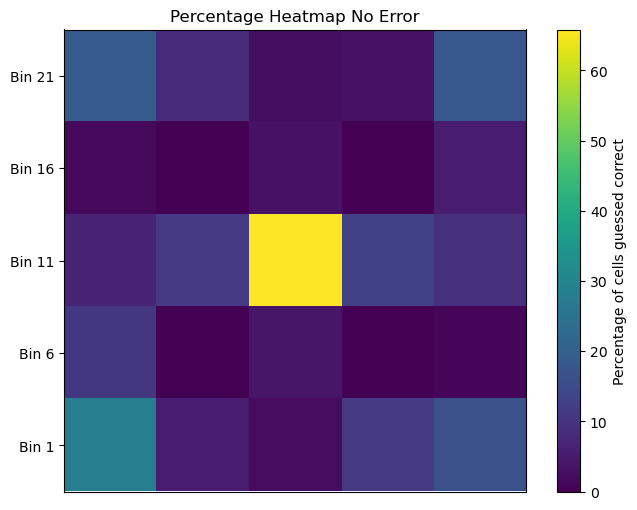

In [505]:
matrix = np.zeros((5, 5))
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = percentages.get(bin_num, 0)
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=np.max(matrix))
plt.colorbar(label='Percentage of cells guessed correct')
plt.xticks(ticks=np.arange(0), labels=[])
plt.yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
plt.title('Percentage Heatmap No Error')
if to_save:
    if not os.path.exists(figsave_dir):
        os.makedirs(figsave_dir)
    plt.savefig(f'{figsave_dir}/prob_distribution_no_error.png', bbox_inches='tight')
plt.show()

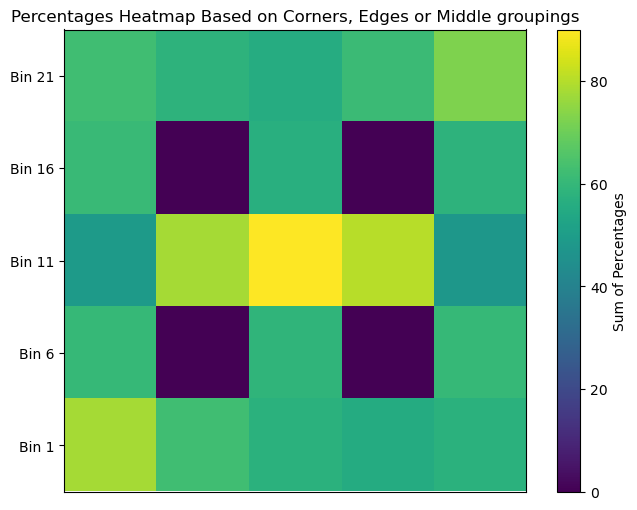

In [506]:
matrix = np.zeros((5, 5))
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

grouping_corners = [1,5,21,25]
grouping_edges = [2,3,4,6,11,16,22,23,24,10,15,20]
grouping_middle = [12,13,14,8,18]

bin_sums = {bin_num: 0 for bin_num in bins}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        percentage_value = percentages.get(bin_num, 0)
        if bin_num in grouping_corners:
            for b in grouping_corners:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_edges:
            for b in grouping_edges:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_middle:
            for b in grouping_middle:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]

for bin_num, total_percentage in bin_sums.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = total_percentage

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Sum of Percentages')
plt.xticks(ticks=np.arange(0), labels=[])
plt.yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
plt.title('Percentages Heatmap Based on Corners, Edges or Middle groupings')
plt.show()

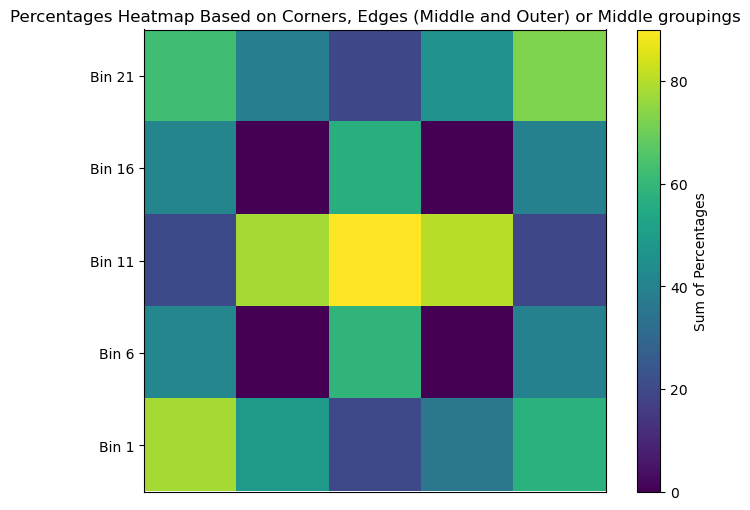

In [507]:
matrix = np.zeros((5, 5))
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

grouping_corners = [1,5,21,25]
grouping_mid_edges = [3,11,23,15]
grouping_middle = [12,13,14,8,18]
grouping_outer_edges = [22,24,6,16,2,4,10,20]
bin_sums = {bin_num: 0 for bin_num in bins}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        if bin_num in grouping_corners:
            for b in grouping_corners:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_mid_edges:
            for b in grouping_mid_edges:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_middle:
            for b in grouping_middle:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_outer_edges:
            for b in grouping_outer_edges:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
                    
for bin_num, total_percentage in bin_sums.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = total_percentage

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Sum of Percentages')
plt.xticks(ticks=np.arange(0), labels=[])
plt.yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
plt.title('Percentages Heatmap Based on Corners, Edges (Middle and Outer) or Middle groupings')
if to_save:
    if not os.path.exists(figsave_dir):
        os.makedirs(figsave_dir)
    plt.savefig(f'{figsave_dir}/prob_distribution_groupings.png', bbox_inches='tight')
plt.show()

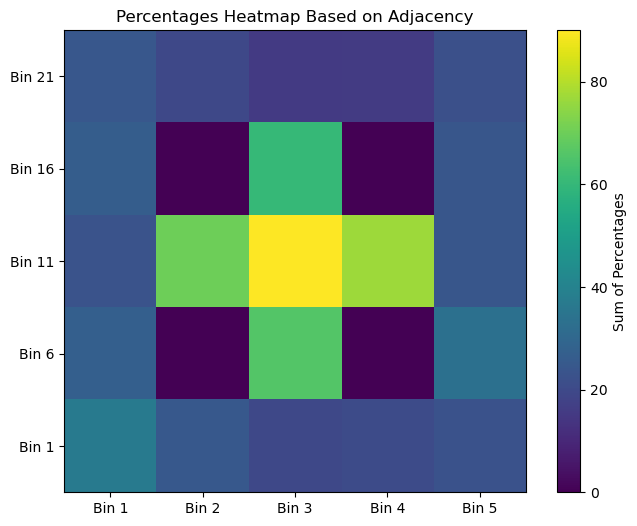

In [509]:
def to_coords(index):
    return index // 5, index % 5

def to_index(row, col):
    return row * 5 + col

def get_neighbors(bin_num):
    if bin_num not in bin_to_index:
        return []
    
    row, col = to_coords(bin_to_index[bin_num])
    neighbors = []
    
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < 5 and 0 <= new_col < 5:
                neighbor_index = to_index(new_row, new_col)
                if neighbor_index in bin_to_index.values():
                    neighbors.append(bins[neighbor_index])
    
    return neighbors

bin_sums = {bin_num: 0 for bin_num in bins}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        neighbors = get_neighbors(bin_num)
        
        total_percentage = 0
        for neighbor in neighbors:
            if neighbor in percentages:
                total_percentage += percentages[neighbor]
        if bin_num in percentages:
            total_percentage += percentages[bin_num]
        bin_sums[bin_num] = total_percentage

for bin_num, total_percentage in bin_sums.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = total_percentage

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Sum of Percentages')
plt.xticks(ticks=np.arange(5), labels=[f'Bin {i}' for i in range(1, 6)])
plt.yticks(ticks=np.arange(5), labels=[f'Bin {i}' for i in range(21, 0, -5)])
plt.title('Percentages Heatmap Based on Adjacency')
if to_save:
    if not os.path.exists(figsave_dir):
        os.makedirs(figsave_dir)
    plt.savefig(f'{figsave_dir}/prob_distribution_adjacency.png', bbox_inches='tight')
plt.show()

In [624]:
from scipy.stats import lognorm
from scipy.stats import expon
from collections import Counter

class BayesCellDecoder:
    def __init__(self, dist):
        self.dist = dist
        self.num_cells = dist.shape[0]
        self.num_bins = dist.shape[1]
        
    def gaussian_pdf(x, mu, sig):
        return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
    
    def __likelihood(self, x, cell, bin):
        mu, sig = self.dist[cell,bin,0], self.dist[cell,bin,1]
        return BayesDecoder.gaussian_pdf(x, mu, sig)
    
    def __predict_cell(self, x, cell):
        posterior = np.zeros(self.num_bins)
        for bin in range(1, self.num_bins):
            prior = self.dist[cell,bin,2]
            posterior[bin] = prior * self.__likelihood(x, cell, bin)
        posterior = np.nan_to_num(posterior, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        pred = np.argmax(posterior[1:])
        return pred, posterior[pred] 

    def predict(self, x):
        prediction, confidence = np.zeros(self.num_cells), np.zeros(self.num_cells)
        for cell in range(self.num_cells):
            pred, conf = self.__predict_cell(x[cell], cell)
            prediction[cell] = pred
            confidence[cell] = conf
        unique_preds, counts = np.unique(prediction, return_counts=True)
        #return lines
        most_common_pred = unique_preds[np.argmax(counts)]
        counts = Counter(prediction)
        most_common = counts.most_common(5)
        total_count = len(prediction)
        unique_proportions = {int(unique + 1): f'{round((count / total_count) * 100, 2)}%' for unique, count in counts.items()}
        cleaned_proportions = {k: float(v.strip('%')) for k, v in unique_proportions.items()}

        top_three_bins = [num + 1 for num, _ in most_common]
        data_array = np.array(prediction)
        incremented_data = data_array + 1
        return incremented_data 
    

In [614]:
for cell, place_responses_per_cell in enumerate(all_place_responses):
    print(cell)
    num_bins = 25
    response_params_per_cell = np.zeros((num_bins+1, 3))
    place_durations_per_cell = all_place_durations[cell]
    for bin, dist in place_responses_per_cell.items():
        total = sum(dist)
        dist= [float(i) / total for i in dist]
        response_params_per_cell[bin,0] = np.mean(dist)
        response_params_per_cell[bin,1] = np.std(dist, ddof=1)
        response_params_per_cell[bin,2] = np.sum(place_durations_per_cell[bin])
    response_params_per_cell[:,2] = response_params_per_cell[:,2] / np.sum(response_params_per_cell[:,2])
    all_place_responses[cell] = response_params_per_cell
all_place_responses = np.array(all_place_responses)

# Clean up large memory variables
del all_place_durations

0


NameError: name 'all_place_durations' is not defined

In [625]:
place_decoder_cells = BayesCellDecoder(all_place_responses)
print(len(valid_cells_distribution))

276


Assembly of sub pseudopopulation

In [655]:
for key, distributions in bins_data.items():
    key_random_values = [random.choice(distribution) for distribution in distributions]
    random_values[key] = key_random_values

cell_correct_counts = defaultdict(int)
cell_total_counts = defaultdict(int)

num_cells = 276

for key in bins_data.keys():
    bin_prediction_list = random_values[key]
    predicted_bin = place_decoder_cells.predict(bin_prediction_list)
    
    for cell in range(num_cells):
        if cell < len(predicted_bin):  
            if predicted_bin[cell] == key:
                cell_correct_counts[cell] += 1
            cell_total_counts[cell] += 1

cell_accuracies = {}
for cell in range(num_cells):
    if cell_total_counts[cell] > 0:
        accuracy = (cell_correct_counts[cell] / cell_total_counts[cell]) * 100
    else:
        accuracy = 0
    cell_accuracies[cell] = accuracy

sorted_cells = sorted(cell_accuracies.items(), key=lambda item: item[1], reverse=True)

print("Top 50 Cells by Accuracy:")
for idx, (cell, accuracy) in enumerate(sorted_cells[:50]):
    print(f"Rank {idx + 1}: Cell {cell}, Accuracy {accuracy:.2f}%")



/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))


Top 50 Cells by Accuracy:
Rank 1: Cell 15, Accuracy 33.33%
Rank 2: Cell 70, Accuracy 33.33%
Rank 3: Cell 123, Accuracy 28.57%
Rank 4: Cell 133, Accuracy 28.57%
Rank 5: Cell 144, Accuracy 28.57%
Rank 6: Cell 178, Accuracy 28.57%
Rank 7: Cell 1, Accuracy 23.81%
Rank 8: Cell 8, Accuracy 23.81%
Rank 9: Cell 16, Accuracy 23.81%
Rank 10: Cell 43, Accuracy 23.81%
Rank 11: Cell 45, Accuracy 23.81%
Rank 12: Cell 48, Accuracy 23.81%
Rank 13: Cell 51, Accuracy 23.81%
Rank 14: Cell 55, Accuracy 23.81%
Rank 15: Cell 82, Accuracy 23.81%
Rank 16: Cell 92, Accuracy 23.81%
Rank 17: Cell 108, Accuracy 23.81%
Rank 18: Cell 132, Accuracy 23.81%
Rank 19: Cell 143, Accuracy 23.81%
Rank 20: Cell 2, Accuracy 19.05%
Rank 21: Cell 9, Accuracy 19.05%
Rank 22: Cell 18, Accuracy 19.05%
Rank 23: Cell 22, Accuracy 19.05%
Rank 24: Cell 24, Accuracy 19.05%
Rank 25: Cell 30, Accuracy 19.05%
Rank 26: Cell 36, Accuracy 19.05%
Rank 27: Cell 41, Accuracy 19.05%
Rank 28: Cell 47, Accuracy 19.05%
Rank 29: Cell 53, Accuracy 1

In [672]:
cell_correct_counts = defaultdict(int)
cell_total_counts = defaultdict(int)
num_runs = 100
num_cells = 276


In [673]:
import random
from collections import defaultdict

def update_running_totals(predictions, actual_keys):
    for key, bin_prediction_list in predictions.items():
        predicted_bin = place_decoder_cells.predict(bin_prediction_list)
        
        for cell in range(num_cells):
            if cell < len(predicted_bin):  
                if predicted_bin[cell] == key:
                    cell_correct_counts[cell] += 1
                cell_total_counts[cell] += 1

def compute_accuracies():
    cell_accuracies = {}
    for cell in range(num_cells):
        if cell_total_counts[cell] > 0:
            accuracy = (cell_correct_counts[cell] / cell_total_counts[cell]) * 100
        else:
            accuracy = 0
        cell_accuracies[cell] = accuracy

    return cell_accuracies

def print_top_cells_by_accuracy(cell_accuracies, top_n=50):
    sorted_cells = sorted(cell_accuracies.items(), key=lambda item: item[1], reverse=True)
    print(f"Top {top_n} Cells by Accuracy:")
    for idx, (cell, accuracy) in enumerate(sorted_cells[:top_n]):
        print(f"Rank {idx + 1}: Cell {cell}, Accuracy {accuracy:.2f}%")

for run in range(num_runs):  
    random_values = {}
    for key, distributions in bins_data.items():
        key_random_values = [random.choice(distribution) for distribution in distributions]
        random_values[key] = key_random_values
    update_running_totals(random_values, bins_data)
cell_accuracies = compute_accuracies()
print_top_cells_by_accuracy(cell_accuracies)

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))


Top 50 Cells by Accuracy:
Rank 1: Cell 92, Accuracy 19.95%
Rank 2: Cell 48, Accuracy 18.38%
Rank 3: Cell 45, Accuracy 17.95%
Rank 4: Cell 51, Accuracy 17.48%
Rank 5: Cell 194, Accuracy 17.33%
Rank 6: Cell 158, Accuracy 17.24%
Rank 7: Cell 203, Accuracy 16.90%
Rank 8: Cell 15, Accuracy 16.86%
Rank 9: Cell 225, Accuracy 16.86%
Rank 10: Cell 128, Accuracy 16.62%
Rank 11: Cell 192, Accuracy 16.52%
Rank 12: Cell 122, Accuracy 16.48%
Rank 13: Cell 41, Accuracy 16.05%
Rank 14: Cell 47, Accuracy 15.76%
Rank 15: Cell 105, Accuracy 15.67%
Rank 16: Cell 5, Accuracy 15.62%
Rank 17: Cell 55, Accuracy 15.52%
Rank 18: Cell 149, Accuracy 15.43%
Rank 19: Cell 108, Accuracy 15.38%
Rank 20: Cell 59, Accuracy 15.29%
Rank 21: Cell 221, Accuracy 15.29%
Rank 22: Cell 22, Accuracy 15.19%
Rank 23: Cell 70, Accuracy 15.14%
Rank 24: Cell 31, Accuracy 15.10%
Rank 25: Cell 162, Accuracy 15.05%
Rank 26: Cell 62, Accuracy 14.86%
Rank 27: Cell 16, Accuracy 14.76%
Rank 28: Cell 146, Accuracy 14.76%
Rank 29: Cell 113, 

In [699]:
list_top_cell_labels = []

def add_top_cells_by_accuracy(cell_accuracies, top_n=50):
    sorted_cells = sorted(cell_accuracies.items(), key=lambda item: item[1], reverse=True)
    print(f"Top {top_n} Cells by Accuracy:")
    for idx, (cell, accuracy) in enumerate(sorted_cells[:top_n]):
        list_top_cell_labels.append(cell + 1)

add_top_cells_by_accuracy(cell_accuracies)
print(list_top_cell_labels)
valid_num_to_cell = {value: key for key, value in valid_cell_to_num.items()}

accurate_cells_list = [valid_num_to_cell[key] for key in list_top_cell_labels if key in valid_num_to_cell]
print(accurate_cells_list)

for cell in accurate_cells_list:
    with open(f'{save_dir}/sub_psuedopop_cells.txt', 'a') as file:
        file.write(cell + '\n')

Top 50 Cells by Accuracy:
[93, 49, 46, 52, 195, 159, 204, 16, 226, 129, 193, 123, 42, 48, 106, 6, 56, 150, 109, 60, 222, 23, 71, 32, 163, 63, 17, 147, 114, 1, 44, 83, 144, 65, 134, 189, 7, 47, 191, 69, 78, 267, 67, 5, 98, 121, 90, 115, 54, 96]
['20180917ch45c1', '20181011ch20c1', '20181015ch20c1', '20181011ch45c2', '20180813ch86c1', '20180827ch29c1', '20180810ch38c1', '20181101ch29c4', '20180730ch43c2', '20180903ch20c1', '20180813ch45c1', '20180904ch29c1', '20181016ch20c1', '20181015ch45c1', '20180910ch17c1', '20181102ch29c1', '20181009ch45c4', '20180828ch45c1', '20180907ch20c2', '20181005ch45c3', '20180731ch45c1', '20181031ch30c1', '20180925ch45c2', '20181022ch9c1', '20180827ch45c1', '20181001ch20c2', '20181101ch30c2', '20180828ch20c1', '20180906ch20c1', '20181105ch29c1', '20181016ch45c1', '20180920ch45c1', '20180829ch45c3', '20181001ch76c1', '20180829ch6c2', '20180814ch45c2', '20181102ch30c1', '20181015ch29c1', '20180813ch21c1', '20180925ch29c1', '20180920ch17c1', '20180705ch76c1', '

In [697]:
bins_data_sub_pop = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in accurate_cells_list:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data_sub_pop:
                bins_data_sub_pop[bin] = []
            bins_data_sub_pop[bin].append(dist)
bins_data_sub_pop

{3: [array([ 2.30373432,  2.93208898,  3.58365083,  3.77245667,  3.87545627,
          4.04915817,  4.14875812,  4.58688081,  4.73903149,  4.79952065,
          4.8077766 ,  4.83598118,  4.87769665,  5.1805763 ,  5.26225676,
          5.37565523,  5.71382776,  5.78064612,  5.94975729,  6.13334121,
          6.13491655,  6.17521115,  6.25069018,  6.68944036,  7.99973883,
          8.26508651,  8.69499471,  8.73577923, 10.46294716, 11.0449355 ,
         11.23763535, 11.69783562, 11.8319278 , 11.9474695 , 12.03092294,
         12.34110291, 13.79967453, 14.94637381, 17.38302223, 18.78522471,
         19.22583878, 21.39811919, 23.6652072 , 24.40272134, 48.32522089]),
  array([ 1.93796591,  2.08736389,  2.2830314 ,  2.80107683,  2.92278738,
          2.94040459,  3.22019044,  3.40054764,  3.64873776,  3.7386015 ,
          3.81649745,  3.87552341,  3.93438892,  3.93438927,  3.93664119,
          3.96844633,  3.99150077,  4.0152217 ,  4.04719068,  4.13055787,
          4.21761268,  4.25122229